## ARES activities report

### Exploratory analysis of the data
(how many records, what variables there are, what they can tell about the distributions of each variable, interesting statistics)

In [2]:
# Imports
from math import log
import itertools
import unidecode
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [3]:
df = pd.read_csv("ARES.csv")
df.head()

,DESCRIPCION,CODIGO_ETAPA,DURACION_HORAS
0,Vacaciones,VAC,8.0
1,Vacaciones,VAC,8.0
2,Documentación proceso multipago bancario ajust...,COCOD,3.0
3,Documentación proceso acumulación pisos y paso...,COCOD,3.0
4,Documentación proceso acumulación pisos y cont...,COCOD,2.0


In [5]:
df.shape

(52856, 3)

In [6]:
df["CODIGO_ETAPA"].nunique()

136

In [7]:
df["CODIGO_ETAPA"].value_counts()

COCOD    20033
ERENT     4972
APEJE     2884
APSEG     1909
PRSIS     1687
         ...  
DELIM        1
AUEJE        1
APPCM        1
CERT         1
PROPO        1
Name: CODIGO_ETAPA, Length: 136, dtype: int64

In [8]:
df.describe()

,DURACION_HORAS
count,52856.000000
mean,2.234706
std,1.421698
min,0.170000
25%,1.000000
50%,2.000000
75%,3.000000
max,13.300000


### Selected stages and justification
(the stages can be differentiated according to the description)

To get the greatest amount of data we will be using the stages with the most observations.

In [9]:
df["CODIGO_ETAPA"].value_counts().head(10)

COCOD      20033
ERENT       4972
APEJE       2884
APSEG       1909
PRSIS       1687
ASEJE       1395
COAJU       1370
EMPALME     1201
COREV       1177
ASSEG       1141
Name: CODIGO_ETAPA, dtype: int64

In [12]:
lista_etapas = ['COCOD','ERENT ','APEJE','APSEG','PRSIS',"ASEJE","COAJU","EMPALME","COREV","ASSEG"]

filtered_df = df[df['CODIGO_ETAPA'].isin(lista_etapas)]
filtered_df.describe()

,DURACION_HORAS
count,32797.000000
mean,2.243011
std,1.247996
min,0.170000
25%,1.500000
50%,2.000000
75%,3.000000
max,13.300000


Notice that that our reduced data fram show us very similar results than the full data frame.

### Part 1: correlation hypothesis (language model using description)

#### Model development

To try to establish a correlation between a stage and its description we will train bigram models for each selected stage: we will use the descriptions of activities in the same stage to count letter frequencies and from there make a prediction using maximum likelihood (logarithm version).

We developed functions to take all descriptions and remove unwanted symbols.

In [2]:
en_alphabet = list(range(97, 123))
en_alphabet_chr = [chr(code) for code in en_alphabet]
all_caracters = list(range(256))
non_alphabetic_en = [simbol for simbol in all_caracters if simbol not in en_alphabet] 

def clean_string(string:str)->str: # Take strings and clean the characters
    string = string.lower()
    string = unidecode.unidecode(string)
    for code in non_alphabetic_en:
        string = string.replace(chr(code), "")
    return string

def get_descriptions(stage:str, database:pd.DataFrame): # Function that receives the stage name, extracts all the descriptions associated with that stage and returns them in a single string
    total = database[database["CODIGO_ETAPA"] == stage]["DESCRIPCION"]
    out = ""
    for index, description in total.items():
        out += description
    return out

Now functions for counting letters and pairs of letters

In [3]:
all_pairs = list(itertools.product(en_alphabet_chr, en_alphabet_chr))
pairs = [x+y for x,y in all_pairs] # list of all letter combinations

def count_pairs(string:str)->dict:
    resume = {pair:0 for pair in pairs}
    parts = []
    for i in range(len(string)-1):
        parts.append(string[i:i+2])
    set_parts = set(parts)
    for pair in set_parts:
        resume[pair] = parts.count(pair)/len(parts)
    return resume

def count_letter(string:str)->dict:
    resume = {letter:0 for letter in en_alphabet_chr}
    if len(string) != 0:
        for letter in en_alphabet_chr:
            resume[letter] = string.count(letter)/len(string)
    return resume

def joint_prob(model_bigram):
    joint = dict()
    keys_list = list(model_bigram.keys())
    for item in keys_list:
        if item[0] != item[1]:
            joint[item] = (model_bigram[item] + model_bigram[item[::-1]])
        else:
            joint[item] = model_bigram[item]
    return joint

We process the database to select the training set and the test set

In [4]:
df = pd.read_csv("ARES.csv")[["CODIGO_ETAPA", "DESCRIPCION"]]
train = pd.DataFrame()
test = pd.DataFrame()
stages_dataframe = pd.DataFrame()
stages = ["COCOD", "ERENT", "APEJE", "APSEG", "PRSIS", "ASEJE", "COAJU", "EMPALME", "COREV", "ASSEG"]
for stage in stages:
    sub_frame = df[df["CODIGO_ETAPA"] == stage] 
    stages_dataframe = pd.concat([stages_dataframe, sub_frame])
    t = sub_frame.sample(n=800, random_state=1)
    train = pd.concat([train, t])
test = stages_dataframe.drop(train.index)

We train the 10 models

In [5]:
def probabilities(stage:str, train=train):
    descriptions = clean_string(get_descriptions(stage, train))
    return joint_prob(count_pairs(descriptions)), count_letter(descriptions)

COCOD_prob_pair, COCOD_prob_letter = probabilities("COCOD")
ERENT_prob_pair, ERENT_prob_letter = probabilities("ERENT")
APEJE_prob_pair, APEJE_prob_letter = probabilities("APEJE")
APSEG_prob_pair, APSEG_prob_letter = probabilities("APSEG")
PRSIS_prob_pair, PRSIS_prob_letter = probabilities("PRSIS")
ASEJE_prob_pair, ASEJE_prob_letter = probabilities("ASEJE")
COAJU_prob_pair, COAJU_prob_letter = probabilities("COAJU")
EMPALME_prob_pair, EMPALME_prob_letter = probabilities("EMPALME")
COREV_prob_pair, COREV_prob_letter = probabilities("COREV")
ASSEG_prob_pair, ASSEG_prob_letter = probabilities("ASSEG")

#### Experiments to test performance
From the available data we used 800 samples of each type of stage to train the model, the remaining rows were used to test the accuracy with which the model can predict at each stage

In [6]:
def log_likelihood_contional(string:str, pair_distribution:dict, letter_distribution:dict):
    result = 0.0
    parts = []
    for i in range(len(string)-1):
        parts.append(string[i:i+2])
    for pair in parts:
        if pair_distribution[pair] != 0:
            result = result + log(pair_distribution[pair]/letter_distribution[pair[0]])
    return result

In [12]:
w = 0
total = train.size
results = {stage:[0, df[df["CODIGO_ETAPA"] == stage].size] for stage in stages}
for row, description in test.iterrows():
    d = clean_string(description[1])
    COCOD = log_likelihood_contional(d, COCOD_prob_pair, COCOD_prob_letter)
    ERENT = log_likelihood_contional(d, ERENT_prob_pair, ERENT_prob_letter)
    APEJE = log_likelihood_contional(d, APEJE_prob_pair, APEJE_prob_letter)
    APSEG = log_likelihood_contional(d, APSEG_prob_pair, APSEG_prob_letter)
    PRSIS = log_likelihood_contional(d, PRSIS_prob_pair, PRSIS_prob_letter)
    ASEJE = log_likelihood_contional(d, ASEJE_prob_pair, ASEJE_prob_letter)
    COAJU = log_likelihood_contional(d, COAJU_prob_pair, COAJU_prob_letter)
    EMPALME = log_likelihood_contional(d, EMPALME_prob_pair, EMPALME_prob_letter)
    COREV = log_likelihood_contional(d, COREV_prob_pair, COREV_prob_letter)
    ASSEG = log_likelihood_contional(d, ASSEG_prob_pair, ASSEG_prob_letter)
    prediction = max([(COCOD, "COCOD"), (ERENT, "ERENT"), (APEJE, "APEJE"), (APSEG, "APSEG"), (PRSIS, "PRSIS"), (ASEJE, "ASEJE"), (COAJU, "COAJU"), (EMPALME, "EMPALME"), (COREV, "COREV"), (ASSEG, "ASSEG")])
    if prediction[1] == description[0]:
        results[description[0]][0]+=1
for key, value in results.items():
    print(f"Stage: {key}, Accuracy: {(value[0]/value[1])*100}%")

Stage: COCOD, Accuracy: 13.260619977037887%
Stage: ERENT, Accuracy: 9.533386967015286%
Stage: APEJE, Accuracy: 10.176837725381414%
Stage: APSEG, Accuracy: 16.84127815610267%
Stage: PRSIS, Accuracy: 17.33847065797273%
Stage: ASEJE, Accuracy: 9.53405017921147%
Stage: COAJU, Accuracy: 8.75912408759124%
Stage: EMPALME, Accuracy: 7.7851790174854285%
Stage: COREV, Accuracy: 4.842820730671198%
Stage: ASSEG, Accuracy: 3.856266432953549%


#### Results
Estos fueron los resultados y creemos que podemos mejorar esto y esto otro

### Segunda parte: calcular la probabilidad del tiempo según etapa (distribución de las horas según la etapa)
La segunda actividad consiste en encontrar distribuciones de probabilidad que se ajusten a las frecuencias de las horas según la etapa

- describir el proceso de elegir una distribución de probabilidad que quieran "encajar" a sus datos
- ejecutar el proceso de estimación de los parametros de su distribucion
- realizar una función que calcule las probabilidades segun unos parametros de entrada.

La funcion final debería ser así: 

In [ ]:
def calcular_prob_PRSIS(x1, x2): 
    # Aca viene la magia que calcula la integral de su PDF entre x1 y x2. 
    # Tengan en cuenta que x2 puede ser inf y x1 puede ser -inf (cuando simplemente digo menor a algo o mayor a algo).     
    # Tambien recuerden que no necesitan integrales... usen solo CDFs
    pass

The times of each stage are processed and stored in an array, which is accessed by means of a dictionary

In [15]:
df = pd.read_csv("ARES.csv")[["CODIGO_ETAPA", "DURACION_HORAS"]]
stages_dataframe = pd.DataFrame() 
stages = ["COCOD", "ERENT", "APEJE", "APSEG", "PRSIS", "ASEJE", "COAJU", "EMPALME", "COREV", "ASSEG"]
data = dict()
for stage in stages:
    sub_frame = df[df["CODIGO_ETAPA"] == stage]
    array = sub_frame["DURACION_HORAS"].to_numpy()
    data[stage] = array

#### Visualization of frequencies and distribution
Below we plot each of the histograms and the corresponding distribution to fit. For this we estimate the parameters using maximum likelihood and scipy tools.

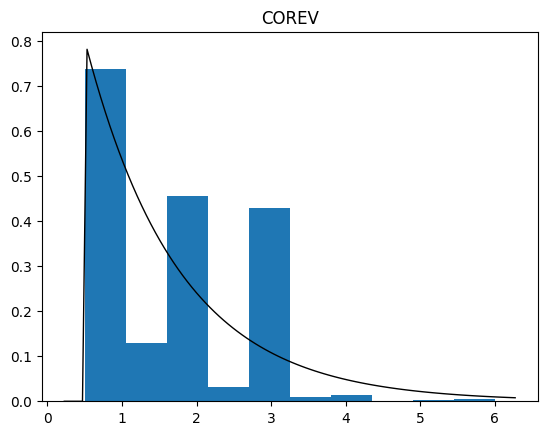

In [21]:
plt.figure()
plt.hist(data["COREV"], density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

loc, scale = stats.expon.fit(data["COREV"])

p = stats.expon.pdf(x, loc, scale)

plt.plot(x, p, 'k', linewidth=1)
title = "COREV"
_ = plt.title(title)

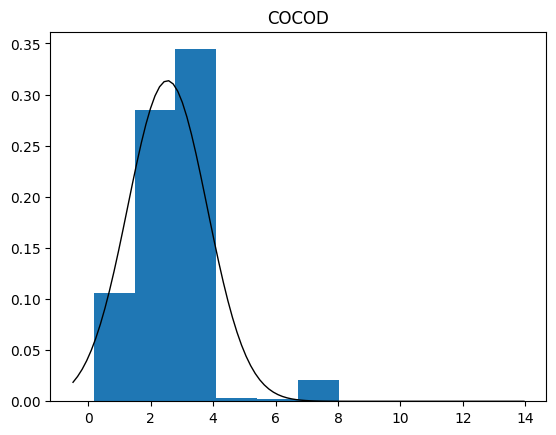

In [20]:
plt.figure()
plt.hist(data["COCOD"], density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

parameters = stats.norm.fit(data["COCOD"])

p = stats.norm.pdf(x,parameters[0], parameters[1])

plt.plot(x, p, 'k', linewidth=1)
title = "COCOD"
_ = plt.title(title)

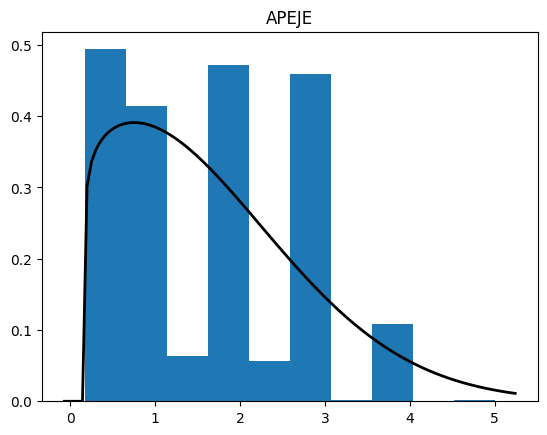

In [23]:
plt.figure()
plt.hist(data["APEJE"],density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

parameters = stats.chi.fit(data["APEJE"])

p = stats.chi.pdf(x,parameters[0],parameters[1],parameters[2])
  
plt.plot(x, p, 'k', linewidth=2)
title = "APEJE"
_ = plt.title(title)

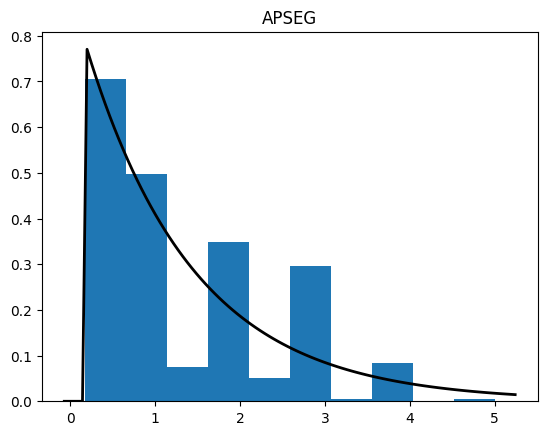

In [25]:
plt.figure()
plt.hist(data["APSEG"], density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

loc, scale = stats.expon.fit(data["APSEG"])

p = stats.expon.pdf(x, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
title = "APSEG"
plt.title(title)
_ = plt.show()

Text(0.5, 1.0, 'PRSIS')

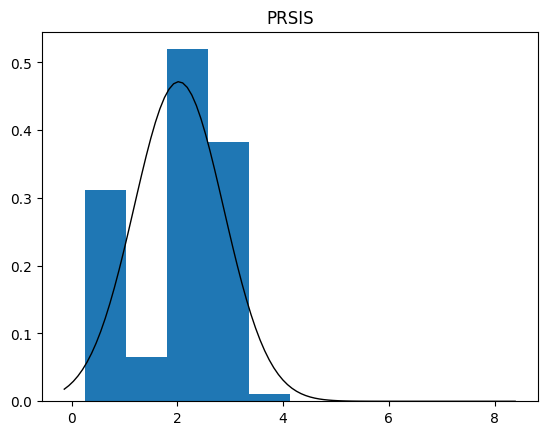

In [27]:
plt.figure()
plt.hist(data["PRSIS"], density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
parameters = stats.norm.fit(data["PRSIS"])
p = stats.norm.pdf(x,parameters[0], parameters[1])
  
plt.plot(x, p, 'k', linewidth=1)
title = "PRSIS"
plt.title(title)

Text(0.5, 1.0, 'ASEJE')

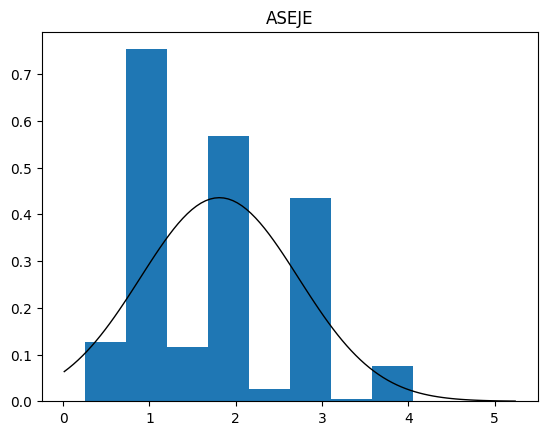

In [28]:
plt.figure()
plt.hist(data["ASEJE"], density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
parameters = stats.norm.fit(data["ASEJE"])
p = stats.norm.pdf(x,parameters[0], parameters[1])
  
plt.plot(x, p, 'k', linewidth=1)
title = "ASEJE"
plt.title(title)

Text(0.5, 1.0, 'COAJU')

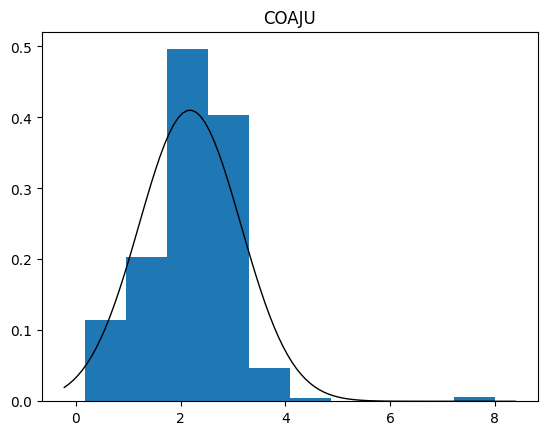

In [29]:
plt.figure()
plt.hist(data["COAJU"], density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
parameters = stats.norm.fit(data["COAJU"])
p = stats.norm.pdf(x,parameters[0], parameters[1])
  
plt.plot(x, p, 'k', linewidth=1)
title = "COAJU"
plt.title(title)

Text(0.5, 1.0, 'EMPALME')

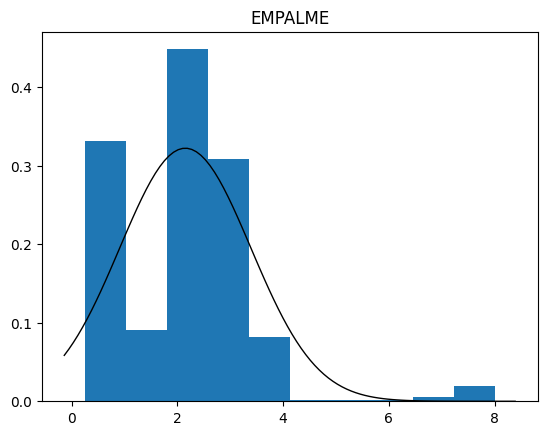

In [30]:
plt.figure()
plt.hist(data["EMPALME"], density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
parameters = stats.norm.fit(data["EMPALME"])
p = stats.norm.pdf(x,parameters[0], parameters[1])
  
plt.plot(x, p, 'k', linewidth=1)
title = "EMPALME"
plt.title(title)

Text(0.5, 1.0, 'ASSEG')

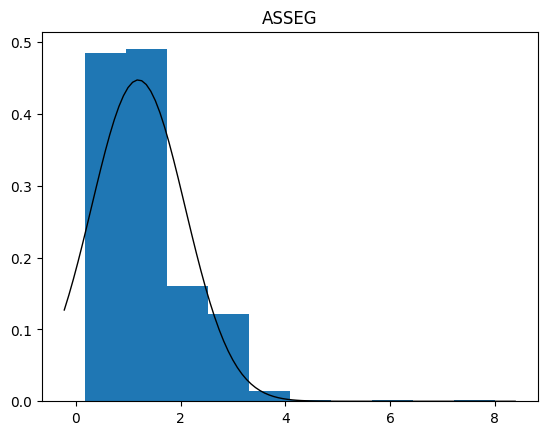

In [31]:
plt.figure()
plt.hist(data["ASSEG"], density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
parameters = stats.norm.fit(data["ASSEG"])
p = stats.norm.pdf(x,parameters[0], parameters[1])
  
plt.plot(x, p, 'k', linewidth=1)
title = "ASSEG"
plt.title(title)

Text(0.5, 1.0, 'ERENT')

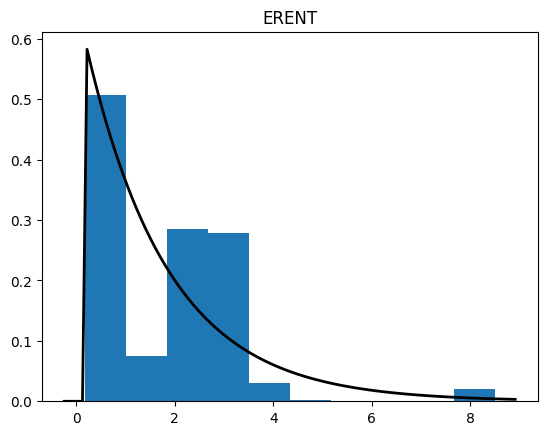

In [32]:
plt.figure(2)
plt.hist(data["ERENT"],density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

loc, scale = stats.expon.fit(data["ERENT"])

p = stats.expon.pdf(x, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
title = "ERENT"
plt.title(title)

#### Functions to calculate probabilities
The following functions take 2 arguments: the lowerbound and the upperbound of the time. Each one returns a probability based on the fitted distributions

In [ ]:
def calculate_prob_COCOD(lower:float, upper:float): 
    parameters = stats.norm.fit(data["COCOD"])
    p1 = stats.norm.cdf(lower,parameters[0], parameters[1])
    p2 = stats.norm.cdf(upper,parameters[0], parameters[1])
    return p2-p1
def calculate_prob_PRSIS(lower:float, upper:float): 
    parameters = stats.norm.fit(data["PRSIS"])
    p1 = stats.norm.cdf(lower,parameters[0], parameters[1])
    p2 = stats.norm.cdf(upper,parameters[0], parameters[1])
    return p2-p1
def calculate_prob_ASEJE(lower:float, upper:float): 
    parameters = stats.norm.fit(data["ASEJE"])
    p1 = stats.norm.cdf(lower,parameters[0], parameters[1])
    p2 = stats.norm.cdf(upper,parameters[0], parameters[1])
    return p2-p1
def calculate_prob_COAJU(lower:float, upper:float): 
    parameters = stats.norm.fit(data["COAJU"])
    p1 = stats.norm.cdf(lower,parameters[0], parameters[1])
    p2 = stats.norm.cdf(upper,parameters[0], parameters[1])
    return p2-p1
def calculate_prob_EMPALME(lower:float, upper:float): 
    parameters = stats.norm.fit(data["EMPALME"])
    p1 = stats.norm.cdf(lower,parameters[0], parameters[1])
    p2 = stats.norm.cdf(upper,parameters[0], parameters[1])
    return p2-p1
def calculate_prob_ASSEG(lower:float, upper:float): 
    parameters = stats.norm.fit(data["ASSEG"])
    p1 = stats.norm.cdf(lower,parameters[0], parameters[1])
    p2 = stats.norm.cdf(upper,parameters[0], parameters[1])
    return p2-p1
def calculate_prob_APEJE(lower:float, upper:float): 
    parameters = stats.chi.fit(data["APEJE"])
    p1 = stats.chi.cdf(lower,parameters[0],parameters[1],parameters[2])
    p2 = stats.chi.cdf(upper,parameters[0],parameters[1],parameters[2])
    return p2-p1
def calculate_prob_COREV(lower:float, upper:float): 
    parameters = stats.expon.fit(data["COREV"])
    p1 = stats.expon.cdf(lower,parameters[0],parameters[1])
    p2 = stats.expon.cdf(upper,parameters[0],parameters[1])
    return p2-p1
def calculate_prob_APSEG(lower:float, upper:float): 
    parameters = stats.expon.fit(data["APSEG"])
    p1 = stats.expon.cdf(lower,parameters[0],parameters[1])
    p2 = stats.expon.cdf(upper,parameters[0],parameters[1])
    return p2-p1
def calculate_prob_ERENT(lower:float, upper:float): 
    parameters = stats.expon.fit(data["ERENT"])
    p1 = stats.expon.cdf(lower,parameters[0],parameters[1])
    p2 = stats.expon.cdf(upper,parameters[0],parameters[1])
    return p2-p1

Finalmente comparar las 10 distribuciones que hayan encontrado y sacar insigths sobre las diferencias o similitudes que vean entre estas